---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment : </td>
<td><h3> 4 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Implementation of Cost Sensitive Logistic Regression </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Manan Darji </td>
<td><h5> CS22MTECH14004 </td>
</tr>
<tr> 
<td><h5> Dhwani Jakhaniya </td>
<td><h5> CS22MTECH14011 </td>
</tr>
<tr> 
<td><h5> Ankit Sharma </td>
<td><h5> CS22MTECH12003 </td>
</tr>
<tr> 
<td><h5> Vishesh Kothari </td>
<td><h5> CS22MTECH12004 </td>
</tr>
<tr> 
<td><h5> Jayanti Mudliar </td>
<td><h5> CS22MTECH14001 </td>
</tr>

<table>



</td>
</tr>
<table>


In [ ]:
! pip install pyea
! pip install joblib

In [ ]:
# importing Libs
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from pyea import GeneticAlgorithmOptimizer
# Difined global color
CLR = (199, 25, 24)
CLR = [x/255 for x in CLR]

In [ ]:
# Reading the CSV file named 'costsensitiveregression.csv' using pandas
data = pd.read_csv('costsensitiveregression.csv')
data.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


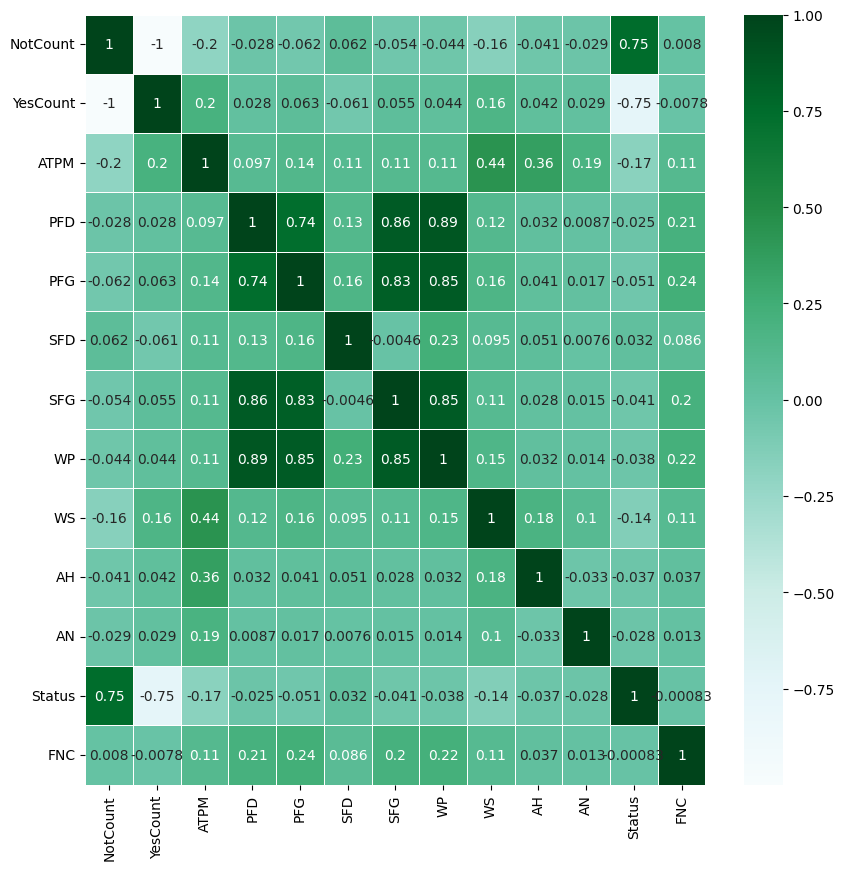

In [ ]:
#heatmap of dataset
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data.corr(), cmap = 'BuGn', annot = True,linewidth=.5,ax=ax)
plt.show()

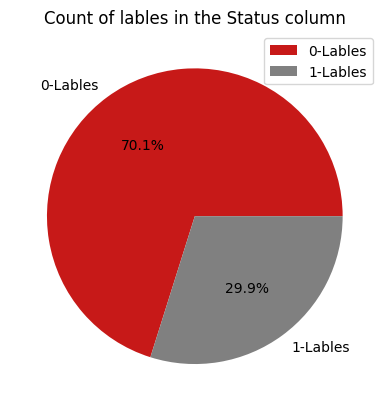

In [ ]:
# Count the number of instances of each label in the 'Status' column of the dataset
status_counts = data['Status'].value_counts()

# Create a list of labels for the pie chart
mylabels = ["0-Lables", "1-Lables"]

# Extract the counts for each label
z = status_counts[0]
o = status_counts[1]

# Create an array of the counts
y = np.array([z, o])
# mycolors = ["black", CLR]
# Create and display a pie chart of the label counts
plt.pie(y,labels=mylabels,autopct='%1.1f%%',colors=[CLR,'gray'])
plt.title('Count of lables in the Status column')
plt.legend()
plt.show() 

In [ ]:
# Separate the independent variables and the dependent variable
X = data.iloc[:, :11]
# class label
y = data.iloc[:, 11]

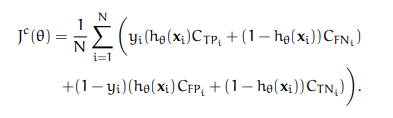

In [ ]:
# calculating the cost using the cost function provided in paper(shared by sir)
def cost_sesitive_logistic_loss(y_true, y_pred, cost_matrix):
    total_loss = y_true * ((1 - y_pred) * cost_matrix[:, 1] + y_pred * cost_matrix[:, 2]) + (1 - y_true) * (y_pred * cost_matrix[:, 0] + (1 - y_pred) * cost_matrix[:, 3])
    return np.sum(total_loss)

# function to calculate the sigmoid function 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

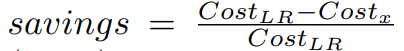

In [ ]:
# function to calculate saving score (traditional LR VS Cost sensitive LR)
def saving_cost(cost_lr,cost_cs):
    saving_score = (cost_lr - cost_cs) / cost_lr
    return saving_score

In [ ]:
def loss(weight, features, target, cost_matrix, alpha):
    if weight.size == features.shape[1] + 1:
        coeff = weight[-1]
        w = weight[:-1]
    else:
        coeff = 0
        w = weight
    probabilities = sigmoid(np.dot(features, w) + coeff)
    loss = cost_sesitive_logistic_loss(target, probabilities, cost_matrix) 
    loss = loss / features.shape[0]
    regularization = 0.5 * alpha * np.dot(w, w)
    return loss + regularization

def total_loss(weights, features, target, cost_matrix, alpha):
    if weights.ndim == 1:
        return loss(weights, features, target, cost_matrix, alpha)
    else:
        return np.array([loss(weight, features, target, cost_matrix, alpha) for weight in weights])

In [ ]:
# class that implements cost-sensitive logistic regression using a genetic algorithm optimizer.
class CostSensitiveLogisticRegression():

    # constructor of the class that initializes the hyperparameters of the model
    def __init__(self, alpha=1, iteration=50, chromosomes=50, mutation=0.25):
        self.alpha = alpha
        self.iteration = iteration
        self.chromosomes = chromosomes
        self.mutation = mutation

    # trains the logistic regression model using the given input features X, target variable y, and cost matrix 
    def training(self, X, y, cost_matrix):
        n_features = X.shape[1]
        weights = np.zeros(n_features + 1)
        optimizer = GeneticAlgorithmOptimizer(total_loss, weights.shape[0], iters=self.iteration, 
                                               n_chromosomes=self.chromosomes, per_mutations=self.mutation, 
                                               type_='cont', fargs=(X, y, cost_matrix, self.alpha))
        optimizer.fit()
        self.c = optimizer.x[:-1]
        self.bias = optimizer.x[-1]
        
    # calculates the predicted probabilities of the target variable for the given input features X
    def prob(self, X):
        y_dash = np.dot(X, self.c) + self.bias
        pred = np.zeros((X.shape[0], 2))
        pred[:, 1] = sigmoid(y_dash)
        pred[:, 0] = 1 - pred[:, 1]
        return pred
        
    # predicts the binary output of the target variable 
    def predict(self, X):
        pred = self.prob(X)
        return np.round(pred[:, 1]).astype(int)

In [ ]:
# Preparing cost matrix
False_positive = np.full(147636, 4)
True_positive = np.full(147636, 4)
True_negative = np.zeros(147636)
cost_matrix = np.column_stack((False_positive, data['FNC'], True_positive, True_negative)).astype(float)

# Split the data into train and test sets
X_train, X_test, y_train, y_test,cost_matrix_train, cost_matrix_test = train_test_split(X, y,cost_matrix, test_size=0.20, random_state=15)

### Check results on Cost sensitive Logistic Regression

In [ ]:
cost_sensitive_logistic_regression = CostSensitiveLogisticRegression()
cost_sensitive_logistic_regression.training(X_train,y_train,cost_matrix_train)
prediction_cs = cost_sensitive_logistic_regression.predict(X_test)

In [ ]:
cost_cs = cost_sesitive_logistic_loss(y_test,prediction_cs,cost_matrix_test)
print("Cost of cost sesitive logistic regression ======>", cost_cs)

Cost of cost sesitive logistic regression ======> 118112.0


### Check results on Traditional Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
traditional_logistic_regression = LogisticRegression()
traditional_logistic_regression.fit(X_train,y_train)
prediction_lr = traditional_logistic_regression.predict(X_test)

In [ ]:
cost_lr = cost_sesitive_logistic_loss(y_test,prediction_lr,cost_matrix_test)
print("Cost of Traditional logistic regression ======>", cost_lr)

Cost of Traditional logistic regression ======> 927321.214688


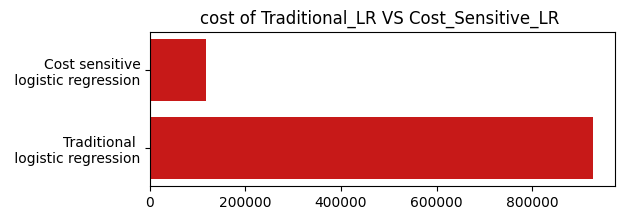

In [ ]:
# showing difference between cost (cost of Cost_sensitive_LR is almost 9-10time lesser than cost of Traditional_LR)
fig, ax = plt.subplots(figsize=(6,2))  
labels = 'Traditional \n logistic regression', 'Cost sensitive\n logistic regression'
values = [cost_lr, cost_cs]
plt.barh(labels, values,align='center',color = CLR)
plt.title('cost of Traditional_LR VS Cost_Sensitive_LR ')
plt.show()

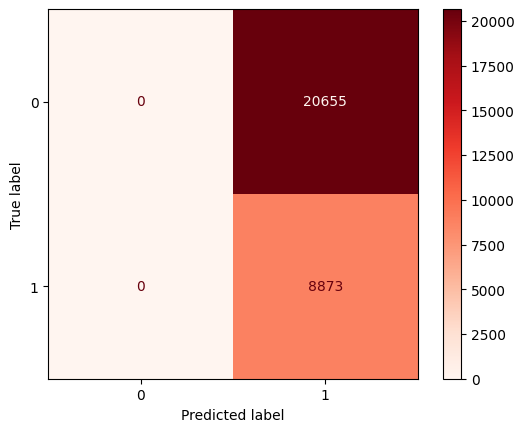

In [ ]:
# calculating confusion matrix and plotting it
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, prediction_cs)
ConfusionMatrixDisplay.from_predictions(y_test, prediction_cs,cmap='Reds')

In [ ]:
# calculating the savings cost
sc = saving_cost(cost_lr,cost_cs)
print("savings cost ======>", sc)

savings cost ======> 0.8726309738964193
